In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import tables

# Summary

# Variance Comparison

In [3]:
tb = np.load('eit_results/bayesian_n=80.npy')
np.save('eit_results/mean_bayes_ed_n=80.npy', tb[-5000:].mean(axis=0))
np.save('eit_results/std_bayes_ed_n=80.npy', tb[-5000:].std(axis=0))

In [27]:
field_pts = np.load('eit_results/field_pts.npy')

In [18]:
n_pts = 80

In [6]:
def cart2pol(*points):
    if len(points) == 1:
        x = points[0][:,0]
        y = points[0][:,1]
    else:
        x = points[0]
        y = points[1]
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.column_stack([rho, phi])

def pol2cart(*points):
    if len(points) == 1:
        rho = points[0][:,0]
        phi = points[0][:,1]
    else:
        rho = points[0]
        phi = points[1]
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.column_stack([x, y])

In [51]:
burn = 5000
samp_base = np.load('eit_results/collocation_n={}.npy'.format(n_pts))
samp_compare = np.load('eit_results/bayesian_n={}.npy'.format(n_pts))
var_base = np.std(np.exp(samp_base[burn:, :len(field_pts)]), axis=0)
var_compare = np.std(np.exp(samp_compare[burn:, :len(field_pts)]), axis=0)

In [52]:
circ_n = 100
circ_r = np.ones(circ_n)
circ_theta = np.linspace(-np.pi, np.pi, circ_n)
circ_points = pol2cart(circ_r, circ_theta)

In [53]:
import matplotlib.tri as tri
def plot_circle(triang, values, colour_range=None, cmap=None, design=None):
    if colour_range is None:
        colour_range = (values.min(), values.max())
    
    plt.tripcolor(triang, values, shading='flat', vmin=colour_range[0], vmax=colour_range[1], cmap=cmap)
    #colors = plt.contourf(test_x, test_y, mu_shaped,  250)
    plt.colorbar()
    if design is not None:
        plt.scatter(design[:,0], design[:,1],  marker='x', c='black', s=50, label='Interior Points')
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
    plt.plot(circ_points[:,0], circ_points[:,1], c='black')

In [54]:
triang = tri.Triangulation(field_pts[:,0], field_pts[:,1])

In [55]:
maskedTris = triang.get_masked_triangles()
verts = np.concatenate((triang.x[maskedTris][..., np.newaxis],
                        triang.y[maskedTris][..., np.newaxis]), axis=2)
def to_triangulation(tri, colors):
    return colors[maskedTris].mean(axis=1)

In [56]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shifted_color_map(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    
    if type(cmap) is str:
        cmap = plt.get_cmap(cmap)
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

0.169105069268


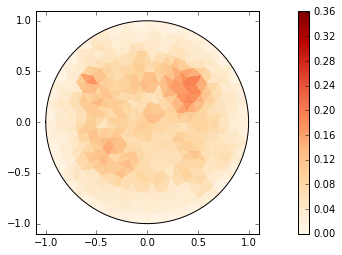

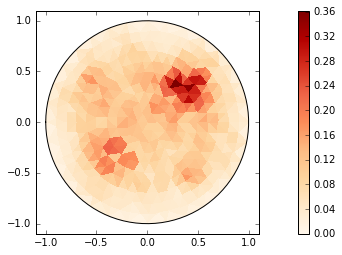

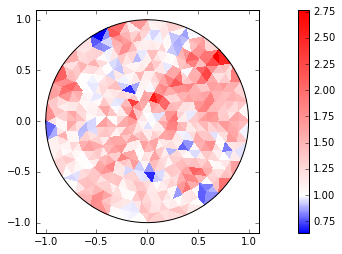

In [57]:
triang_var_base = to_triangulation(triang, var_base)
triang_var_compare = to_triangulation(triang, var_compare)
ratio = triang_var_compare / triang_var_base

max_var = max(triang_var_base.max(), triang_var_compare.max())

cmap = 'OrRd'

plt.figure()
plot_circle(triang, triang_var_base, colour_range=(0, max_var), cmap=cmap)
plt.savefig('figures/eit_variance_n={}_collocation.pdf'.format(n_pts), transparent=True, bbox_inches=0)
plt.figure()
plot_circle(triang, triang_var_compare, colour_range=(0, max_var), cmap=cmap)
plt.savefig('figures/eit_variance_n={}.pdf'.format(n_pts), transparent=True, bbox_inches=0)
plt.figure()

new_mid = (1. - ratio.min()) /(ratio.max()-ratio.min())
print new_mid
shift_cm = shifted_color_map('bwr', midpoint=new_mid)
plot_circle(triang, ratio, cmap=shift_cm)
plt.savefig('figures/eit_variance_n={}_compare.pdf'.format(n_pts), transparent=True, bbox_inches=0)

# Plot conductivity fields

In [14]:
burn = 5000
truth = 'sim_data/truth2.txt'
true_diff = np.loadtxt(truth)
means = {}
ns = np.array([80, 160, 240])
errors = np.empty_like(ns, dtype=np.float)

for ix, n in enumerate(ns):
    fname = 'eit_results/bayesian_n={}.npy'.format(n)
    samples = np.load(fname)
    mean = np.mean(samples[burn:, :len(field_pts)], axis=0)
    means[n] = to_triangulation(triang, np.exp(mean))
    errors[ix] = np.linalg.norm(np.exp(mean) - np.exp(true_diff[:len(field_pts),2]), 2)

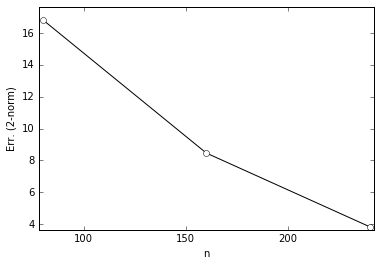

In [15]:
plt.plot(ns, errors, marker='o', color='black', markerfacecolor='white')
plt.xlim(ns.min()-2, ns.max()+2)
plt.ylim(errors.min()*0.95, errors.max()*1.05)
plt.xlabel('n')
plt.ylabel('Err. (2-norm)')
plt.savefig('figures/eit_conductivity_error.pdf', transparent=True, bbox_inches=0)

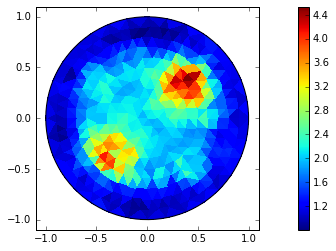

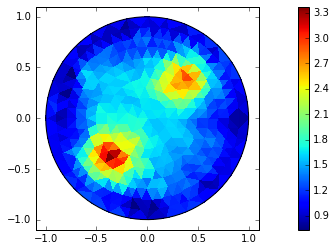

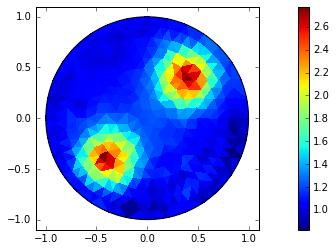

In [16]:
vmin = min([np.min(v) for v in means.values()])
vmax = max([np.max(v) for v in means.values()])
for n in ns:
    colors = means[n]
    plt.figure()
    plot_circle(triang, colors)#, (vmin, vmax))
    plt.savefig('figures/eit_conductivity_n={}.pdf'.format(n), transparent=True, bbox_inches=0)

In [20]:
means.values()

[array([  1.31760299e-01,   2.01328773e-01,   1.05871929e-01,
          8.46814193e-03,   6.69181298e-03,   7.47587420e-03,
          1.23609692e-01,   8.18565154e-01,   1.83382945e-01,
          1.96912568e-01,   2.95357965e-06,   3.46744251e-06,
          6.31877274e-02,   3.34204296e-01,   4.22406087e-01,
          3.23455508e-01,   1.62034196e-01,   1.66543232e-01,
          2.25362917e-01,   8.15352397e-02,   1.73404334e-01,
          2.09771861e-04,   6.29638780e-04,   2.30046036e-06,
          1.95460519e-06,   6.25525822e-06,   3.37896056e-05,
          8.58427979e-06,   2.73976542e-06,   2.35022847e-06,
          2.68900812e-05,   3.11159614e-04,   1.51194748e-04,
          5.05863667e-02,   1.09012415e-03,   1.92720064e-05,
          1.52380651e-05,   4.20797974e-04,   2.50177687e-04,
          4.75663553e-03,   1.18954905e-03,   1.12939006e-03,
          1.67314320e-01,   1.32364340e-01,   1.73185571e-01,
          2.62557671e-01,   2.52441471e-01,   1.63919648e-01,
        